# XRL and Influence Functions

This file contains code used for generating results of the gridworld experiments.

In [73]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [74]:
import warnings
warnings.filterwarnings("ignore")

# Regular data science libraries
import numpy as np
import pandas as pd
import json
import os
import pickle
import random
from os import path

#new additions for D4RL
import mujoco_py
import gym
import d4rl
import d3rlpy
from pathlib import Path
import matplotlib.pyplot as plt
import math
import time


# DNN libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# Import utility functions from other files
from utils import generate_model, dp, generate_offline_data
from env import Agent, Environment


# Plotting libraries
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import scienceplots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('ieee')


# Clustering libraries
from sklearn.decomposition import PCA
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster.xmeans import xmeans
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import SIMPLE_SAMPLES
from scipy.stats import wasserstein_distance

# Set the seeds
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)

### Instantiate the Environment

Pick one of the three provided environments: FourRooms, 7x7 (default), or 5x5. The environment implementation is provided in a script attached with this notebook.

In [78]:
from d3rlpy.datasets import get_d4rl
from d3rlpy.dataset import MDPDataset

env = gym.make('Pendulum-v1')
#sac_orig = d3rlpy.algos.SAC()
#os.chdir('d3rlpy_logs/Nov0_DEF')
#sac_orig.build_with_env(env)
#sac_orig.build_with_dataset(short_dataset)
#sac_orig.load_model('model_50000.pt')
#policy_orig = sac_orig.impl.policy
#policy_orig.load_state_dict(checkpoint['_policy'])
#policy_orig.to(device)
#os.chdir('../../')
# Define a random policy function
def random_policy(observation):
    # The action space for Pendulum is continuous, so sample a random action
    #observation = torch.tensor(observation)
    #print([observation])
    #ans = sac_orig.predict([observation])[0] * 2
    #print(ans)
    #return ans
    return env.action_space.sample()

# Run 200 episodes
num_episodes = 100
episode_observations = np.zeros((7960, 3))
episode_actions = np.zeros((7960, 1))
episode_rewards = np.zeros([7960])
episode_terminals = np.zeros([7960])

for episode in range(40):
    observation = env.reset()
    done = False
    total_reward = 0

    for step in range(199):
        # Choose a random action using the random policy
        action = random_policy(observation)
        
        # Take the action in the environment
        observation, reward, done, info = env.step(action)
        observation = env.reset()
        
        # Accumulate the reward for this episode
        episode_observations[episode * 199 + step][0], episode_observations[episode * 199 + step][1], episode_observations[episode * 199 + step][2] = observation[0], observation[1], observation[2]
        episode_actions[episode * 199 + step][0] = action[0]
        episode_rewards[episode * 199 + step] = reward
        if step == 198:
            episode_terminals[episode * 199 + step] = (1.0)
        else:
            episode_terminals[episode * 199 + step] = (0.0)
        
short_dataset = MDPDataset(episode_observations[:7960], episode_actions[:7960], episode_rewards[:7960], episode_terminals[:7960])
print(len(short_dataset))
print(len(episode_observations))

train_dataset = []
for i in range(len(short_dataset.episodes)):
    episode = short_dataset.episodes[i]
    for j in range(len(episode)):
        train_dataset.append([episode.observations[j], episode.actions[j][0]])
print(len(train_dataset))
    # Store the total reward for this episode

40
7960
7960


In [43]:
os.chdir('xrl_with_trajectories')
print(os.listdir())

['env.py', 'ans.png', 'rollout', 'ansOn.png', 'gridworld_results', '.gitignore', 'gridworld', 'ansOff.png', 'outdir', 'traj_clustering_grid.pdf', '.ipynb_checkpoints', 'gym_example', '.DS_Store', 'd3rlpy_data', 'utils.py', 'assets', 'gridworld_expts.ipynb', 'online_models', 'pytorch_influence_functions', 'ckpt_save_dir', '.git', 'd3rlpy_logs', 'requirements.txt', 'influence_functions.ipynb', '__pycache__', 'README.md', 'LICENSE']


In [29]:
from d3rlpy.datasets import get_d4rl
from d3rlpy.dataset import MDPDataset

#dataset, env = get_d4rl('halfcheetah-expert-v2')
dataset, env = d3rlpy.datasets.get_pendulum('random')
ep_num = 50
num = 199 * ep_num
short_dataset = MDPDataset(dataset.observations[:num], dataset.actions[:num], dataset.rewards[:num], dataset.episode_terminals[:num])
episodes = short_dataset.episodes

#alt_dataset = MDPDataset(alt_obs, alt_act, alt_rew, alt_ter)

#There are 500 episodes, each with 200 steps.
#print(len(short_dataset.episodes))
#print(len(short_dataset.episodes[0]))
#print(len(short_dataset.episodes[99]))

train_dataset = []
for i in range(len(short_dataset.episodes)):
    episode = short_dataset.episodes[i]
    for j in range(len(episode)):
        train_dataset.append([episode.observations[j], episode.actions[j][0]])
        #print([episode.observations[j], episode.actions[j][0]])
    #observation = np.mean(episode.observations, 0)
    #ction = np.mean(episode.actions, 0)
    #observations.append(observation)
    #actions.append(action)
#observations = np.array(observations)
#actions = np.array(actions)
print(len(train_dataset))

9950


In [9]:
class LinearModel(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
    def forward(self, x):
        return self.linear(x)


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
for i in range(40):
    model = LinearModel(3, 1)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    temp_obs = torch.tensor(np.concatenate((short_dataset.observations[:i * 199], short_dataset.observations[(i + 1) * 199:])))
    temp_act = torch.tensor(np.concatenate((short_dataset.actions[:i * 199], short_dataset.actions[(i + 1) * 199:])))
    print(len(temp_obs), len(temp_act))
    training_set = TensorDataset(temp_obs, temp_act)
    data_loader_set = DataLoader(training_set, batch_size = 256, shuffle = True)

    epochs = 50
    #for epoch in range(epochs):
    for epoch in range(epochs):
        running_loss = 0.0
        for batch_idx, (state_batch, action_batch) in enumerate(data_loader_set):
            # Forward pass: compute predicted actions by passing states through the model
            predicted_actions = model(state_batch)
            
            # Compute the loss (difference between predicted actions and offline actions)
            loss = criterion(predicted_actions, action_batch)
            
            # Zero gradients, backpropagate, and update the weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Accumulate loss for monitoring
            running_loss += loss.item()
        
        # Print average loss for each epoch
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(data_loader_set):.4f}')
        os.chdir('d3rlpy_logs/Linear')
        print(os.listdir())
        name = "model_" + str(i) + "_.pth"
        torch.save(model.state_dict(), name)
        os.chdir('../../')

Epoch [1/50], Loss: 1.9859
['model14.pth', 'model13.pth', 'model28.pth', 'model9.pth', 'model26.pth', 'model7.pth', 'model0.pth', 'model21.pth', 'model30.pth', 'model37.pth', 'model39.pth', 'model1.pth', 'model20.pth', 'model27.pth', 'model6.pth', 'model29.pth', 'model8.pth', 'model12.pth', 'model15.pth', 'model38.pth', 'model36.pth', 'model31.pth', 'model32.pth', 'model35.pth', 'model24.pth', 'model5.pth', 'model2.pth', 'model23.pth', 'default.pth', 'model18.pth', 'model16.pth', 'model11.pth', 'model34.pth', 'model33.pth', 'model10.pth', 'model17.pth', 'model19.pth', 'model3.pth', 'model22.pth', 'model25.pth', 'model4.pth']
Epoch [2/50], Loss: 1.9562
['model14.pth', 'model13.pth', 'model28.pth', 'model9.pth', 'model26.pth', 'model7.pth', 'model0.pth', 'model21.pth', 'model30.pth', 'model37.pth', 'model39.pth', 'model1.pth', 'model20.pth', 'model27.pth', 'model6.pth', 'model29.pth', 'model8.pth', 'model12.pth', 'model15.pth', 'model38.pth', 'model36.pth', 'model31.pth', 'model32.pth', 

In [70]:
import influence_functions as influence

#os.chdir('d3rlpy_logs/Linear')
#alt_model = LinearModel(3, 1)
#print(os.listdir())
#alt_model.load_state_dict(torch.load('model0.pth'))
#os.chdir('../../')



obs = short_dataset[12].observations[100]
act = short_dataset[12].actions[100]
test_dataset = [[obs, act[0]]]
print(test_dataset)
influence.calcInfluence(train_dataset, test_dataset, model)

[[array([0.8882703 , 0.45932105, 0.9489816 ], dtype=float32), 1.5043318]]
Feature batch shape: torch.Size([1, 3])
Labels batch shape: torch.Size([1])
Feature batch shape: torch.Size([1, 3])
Labels batch shape: torch.Size([1])
1.5043318


KeyboardInterrupt: 

In [5]:
print(short_dataset.observations)

[[-0.99831885  0.05796078 -0.76389396]
 [ 0.7986122   0.601846   -0.6733353 ]
 [-0.37045062 -0.92885214 -0.93134683]
 ...
 [-0.7925842   0.60976255  0.15609047]
 [-0.17922398 -0.9838083  -0.9661635 ]
 [-0.4719408   0.88163024  0.92148846]]


In [10]:
os.chdir('d3rlpy_logs/Linear')
print(os.listdir())
#torch.save(model.state_dict(), 'default.pth')
os.chdir('../../')

['model14.pth', 'model13.pth', 'model28.pth', 'model9.pth', 'model26.pth', 'model7.pth', 'model0.pth', 'model21.pth', 'model30.pth', 'model37.pth', 'model39.pth', 'model1.pth', 'model20.pth', 'model27.pth', 'model6.pth', 'model29.pth', 'model8.pth', 'model12.pth', 'model15.pth', 'model38.pth', 'model36.pth', 'model31.pth', 'model32.pth', 'model35.pth', 'model24.pth', 'model5.pth', 'model2.pth', 'model23.pth', 'default.pth', 'model18.pth', 'model16.pth', 'model11.pth', 'model34.pth', 'model33.pth', 'model10.pth', 'model17.pth', 'model19.pth', 'model3.pth', 'model22.pth', 'model25.pth', 'model4.pth']


In [5]:
def addToTrain():
    for i in range(10):
        rollout = 'rollout/rollout' + str(i) + '.json'
        with open (rollout, 'r') as file:
            output_dict = json.load(file)

        out_states = output_dict['states']
        out_actions = output_dict['actions']
        out_rewards = output_dict['rewards']
        out_episode_terminals = output_dict['episode_terminals']

        #print(out_states)
        #print(out_actions)
        #print(out_rewards)
        #print(out_episode_terminals)
        #print("###")
        #print(train_dataset)

        #print(len(train_dataset))
        for i in range(len(out_states)):
            train_dataset.append([np.array(out_states[i], dtype = np.float32), out_actions[i][0]])
        #print(len(train_dataset))

def addToMDP(i):
    rollout = 'rollout/rollout' + str(i) + '.json'
    with open (rollout, 'r') as file:
        output_dict = json.load(file)
    new_obs = np.array(output_dict['states'])
    new_act = np.array(output_dict['actions'])
    new_rewards = np.array(output_dict['rewards'])
    print(np.min(new_obs[:, 0]), np.max(new_obs[:, 0]))
    print(np.min(new_obs[:, 1]), np.max(new_obs[:, 1]))
    print(np.min(new_obs[:, 2]), np.max(new_obs[:, 2]))
    print(np.min(new_act), np.max(new_act))
    print(np.min(new_rewards), np.max(new_rewards))
    out_states = np.array(new_obs)
    out_actions = new_act
    out_rewards = new_rewards
    out_episode_terminals = np.array(output_dict['episode_terminals'])
    tempDataset = MDPDataset(out_states, out_actions, out_rewards, out_episode_terminals)
    print(len(tempDataset))
    short_dataset.extend(tempDataset)

print(len(short_dataset))
addToTrain()
for i in range(10):
    addToMDP(i)
print(len(short_dataset))


40
-0.9999570846557617 0.9920300245285034
-0.9996150732040405 0.9999999403953552
-0.6319992542266846 7.7272047996521
-1.715338945388794 1.9311341047286987
-15.492784457941491 -0.0002309959098106616
1
-0.9999393820762634 0.9999877214431763
-0.9999994039535522 0.9998148679733276
-7.663499355316162 6.272202968597412
-1.9497053623199463 1.9663342237472534
-15.42986739595216 -0.0003794982391586063
1
-0.9945640563964844 0.9975616931915283
-0.9939250349998474 0.9999991059303284
-0.2887129485607147 7.801939010620117
-1.7062907218933105 1.9143894910812378
-14.95046929134494 -0.0002320194037485815
1
-0.9993798732757568 0.9998747110366821
-0.9999011158943176 0.9999998807907104
-6.270023345947266 7.5466227531433105
-1.9339606761932373 1.946884274482727
-15.22799216805923 -0.00023111118210700853
1
-0.9984188079833984 0.99387127161026
-0.9996426105499268 0.9999993443489075
-5.208962440490723 6.903311729431152
-1.9580955505371094 1.9984245300292969
-13.726701371862564 -0.00023178805500700405
1
-0.991

In [5]:
from d3rlpy.preprocessing import MinMaxScaler, ActionScaler, RewardScaler, MinMaxActionScaler, MinMaxRewardScaler, MultiplyRewardScaler, MinMaxScaler

class CustomMinMaxActionScaler(ActionScaler):
    def __init__(self, min_val=-1.0, max_val=1.0):
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, x):
        pass  # No fitting needed for min-max scaler

    def transform(self, x):
        return (x - self.min_val) / (self.max_val - self.min_val) * 2 - 1  # Scale to [-1, 1]

    def reverse_transform(self, x):
        return (x + 1) / 2 * (self.max_val - self.min_val) + self.min_val  # Scale back to original range

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

class CustomMinMaxRewardScaler(RewardScaler):
    def __init__(self, min_val=-16.2736044, max_val=0.0):
        self.min_val = min_val
        self.max_val = max_val

    def fit(self, x):
        pass  # No fitting needed for min-max scaler

    def transform(self, x):
        return (x - self.min_val) / (self.max_val - self.min_val) * 2 - 1  # Scale to [-1, 1]

    def reverse_transform(self, x):
        return (x + 1) / 2 * (self.max_val - self.min_val) + self.min_val  # Scale back to original range

    def fit_transform(self, x):
        self.fit(x)
        return self.transform(x)

In [6]:
import torch
print(torch.cuda.get_device_name(0))
print(torch.cuda.device_count())
print(torch.cuda.current_device())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
#!echo $CUDA_VISIBLE_DEVICES

if torch.cuda.is_available():
    print(f"Number of GPUs: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i} Name: {torch.cuda.get_device_name(i)}")
        print(f"GPU {i} Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
        print(f"GPU {i} Memory Cached: {torch.cuda.memory_reserved(i)} bytes")
else:
    print("CUDA is not available.")

NVIDIA GeForce RTX 2080 Ti
1
0
cuda:0
Number of GPUs: 1
GPU 0 Name: NVIDIA GeForce RTX 2080 Ti
GPU 0 Memory Allocated: 0 bytes
GPU 0 Memory Cached: 0 bytes


In [8]:
#print(short_dataset.observations)
#short_dataset.observations[:, 2] = short_dataset.observations[:, 2]
#print(short_dataset.observations)
#print(episode_observations.shape)
print(np.max(short_dataset.observations[:, 2]))
print(np.min(short_dataset.observations[:, 2]))
print(np.max(short_dataset.observations[:, 1]))
print(np.max(short_dataset.observations[:, 0]))
print(short_dataset.observations)
#print(np.max(episode_actions))
#print(np.max(episode_rewards))

0.9995096
-0.9999921
0.9999996
0.9999999
[[-0.3076959   0.95148474  0.94864947]
 [ 0.11445573 -0.99342835  0.95997655]
 [ 0.13060318 -0.9914347   0.35048616]
 ...
 [ 0.8361422   0.54851276 -0.42987648]
 [ 0.9766187   0.21497895  0.8063494 ]
 [-0.9216784   0.38795477 -0.3609935 ]]


In [6]:
from d3rlpy.metrics.scorer import td_error_scorer
from d3rlpy.metrics.scorer import average_value_estimation_scorer
from d3rlpy.metrics.scorer import evaluate_on_environment

# prepare algorithm
#sac = d3rlpy.algos.SAC(action_scaler="min_max")
# train offline
#for i in range(97, 100, 1):
for j in range(18, 30, 1):
    for i in range(1):
        idx = j
        alt_obs = np.concatenate((short_dataset.observations[:idx * 199], short_dataset.observations[(idx + 1) * 199:]))
        alt_act = np.concatenate((short_dataset.actions[:idx * 199], short_dataset.actions[(idx + 1) * 199:]))
        alt_rew = np.concatenate((short_dataset.rewards[:idx * 199], short_dataset.rewards[(idx + 1) * 199:]))
        alt_ter = np.concatenate((short_dataset.episode_terminals[:idx * 199], short_dataset.episode_terminals[(idx + 1) * 199:]))
        alt_dataset = MDPDataset(alt_obs, alt_act, alt_rew, alt_ter)

        #test_obs = episode_observations[7960:11940]
        #test_act = episode_actions[7960:11940]
        #test_rew = episode_rewards[7960:11940]
        #test_ter = episode_terminals[7960:11940]
        #test_dataset = MDPDataset(test_obs, test_act, test_rew, test_ter)
        #train_dataset = []
        #for j in range(len(alt_dataset.episodes)):
        #    episode = alt_dataset.episodes[j]
        #    for k in range(len(episode)):
        #        train_dataset.append([episode.observations[k], episode.actions[k][0]])
        #print(len(train_dataset))
        print(len(short_dataset))
        print(len(alt_dataset))
        #print(len(test_dataset))
        print(np.min(alt_dataset.observations[:, 2]), np.max(alt_dataset.observations[:, 2]))
        print(np.min(alt_dataset.observations[:, 1]), np.max(alt_dataset.observations[:, 1]))
        print(np.min(alt_dataset.observations[:, 0]), np.max(alt_dataset.observations[:, 0]))
        print(np.min(alt_dataset.actions), np.max(alt_dataset.actions))
        print(np.min(alt_dataset.rewards), np.max(alt_dataset.rewards))
        #print(np.min(test_dataset.observations[:, 2]), np.max(test_dataset.observations[:, 2]))
        #print(np.min(test_dataset.observations[:, 1]), np.max(test_dataset.observations[:, 1]))
        #print(np.min(test_dataset.observations[:, 0]), np.max(test_dataset.observations[:, 0]))
        #print(np.min(test_dataset.actions), np.max(test_dataset.actions))
        #print(np.min(test_dataset.rewards), np.max(test_dataset.rewards))
        name = "SHORT" + str(idx)
        sac = d3rlpy.algos.SAC(action_scaler = MinMaxActionScaler(alt_dataset), reward_scaler = MultiplyRewardScaler(1/16.2736044), use_gpu = True)
        #sac = d3rlpy.algos.SAC(use_gpu = True)
        #sac.fit(alt_dataset, n_steps=50000, experiment_name = name, eval_episodes = test_dataset.episodes, scorers = {'td_error': td_error_scorer, 'environment': evaluate_on_environment(env)})
        sac.fit(alt_dataset, n_steps=50000, experiment_name = name)
# ready to control      
#actions = sac.predict(x)

40
39
-8.0 8.0
-0.9999999 0.9999983
-1.0 0.9999995
-2.0 2.0
-16.26149 -0.0022730427
2024-09-23 17:06:09 [debug    ] RandomIterator is selected.   
2024-09-23 17:06:09 [info     ] Directory is created at d3rlpy_logs/SHORT18_20240923170609
2024-09-23 17:06:09 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-23 17:06:09 [debug    ] Fitting reward scaler...       reward_scaler=multiply
2024-09-23 17:06:09 [debug    ] Building models...            


KeyboardInterrupt: 

In [42]:
name = "SHORTDEFAULT"
print(len(short_dataset))
sac = d3rlpy.algos.SAC(action_scaler = MinMaxActionScaler(alt_dataset), reward_scaler = MultiplyRewardScaler(1/16.2736044), use_gpu = True)
sac.fit(short_dataset, n_steps=50000, experiment_name = name)

50
2024-09-23 07:38:29 [debug    ] RandomIterator is selected.   
2024-09-23 07:38:29 [info     ] Directory is created at d3rlpy_logs/SHORTDEFAULT_20240923073829
2024-09-23 07:38:29 [debug    ] Fitting action scaler...       action_scaler=min_max
2024-09-23 07:38:29 [debug    ] Fitting reward scaler...       reward_scaler=multiply
2024-09-23 07:38:29 [debug    ] Building models...            
2024-09-23 07:38:29 [debug    ] Models have been built.       
2024-09-23 07:38:29 [info     ] Parameters are saved to d3rlpy_logs/SHORTDEFAULT_20240923073829/params.json params={'action_scaler': {'type': 'min_max', 'params': {'minimum': array([[-2.]], dtype=float32), 'maximum': array([[2.]], dtype=float32)}}, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-23 07:45:13 [info     ] SHORTDEFAULT_20240923073829: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0024567358016967774, 'time_algorithm_update': 0.03663033514022827, 'temp_loss': 0.577348540507257, 'temp': 0.3706813784271479, 'critic_loss': 0.13857980843922124, 'actor_loss': 0.7465344259040431, 'time_step': 0.03998156101703644} step=10000
2024-09-23 07:45:13 [info     ] Model parameters are saved to d3rlpy_logs/SHORTDEFAULT_20240923073829/model_10000.pt


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-23 07:52:00 [info     ] SHORTDEFAULT_20240923073829: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.0024573418140411375, 'time_algorithm_update': 0.036940245032310484, 'temp_loss': 0.027020912649517413, 'temp': 0.0510562693381682, 'critic_loss': 0.45579658803232015, 'actor_loss': 4.5341892071008685, 'time_step': 0.0403187569141388} step=20000
2024-09-23 07:52:01 [info     ] Model parameters are saved to d3rlpy_logs/SHORTDEFAULT_20240923073829/model_20000.pt


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-23 07:58:49 [info     ] SHORTDEFAULT_20240923073829: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.002460922908782959, 'time_algorithm_update': 0.0370866367816925, 'temp_loss': 8.212830572520033e-05, 'temp': 0.02580138046424836, 'critic_loss': 0.3772210827142, 'actor_loss': 3.5042949988126755, 'time_step': 0.040471789717674254} step=30000
2024-09-23 07:58:49 [info     ] Model parameters are saved to d3rlpy_logs/SHORTDEFAULT_20240923073829/model_30000.pt


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-23 08:05:38 [info     ] SHORTDEFAULT_20240923073829: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.002469071102142334, 'time_algorithm_update': 0.03706751461029053, 'temp_loss': -5.07953450010973e-05, 'temp': 0.024403936773724853, 'critic_loss': 0.33364662262387573, 'actor_loss': 3.083142717003822, 'time_step': 0.04046419591903686} step=40000
2024-09-23 08:05:38 [info     ] Model parameters are saved to d3rlpy_logs/SHORTDEFAULT_20240923073829/model_40000.pt


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-09-23 08:12:27 [info     ] SHORTDEFAULT_20240923073829: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.0024727492094039918, 'time_algorithm_update': 0.03702627816200257, 'temp_loss': -0.00046633148559194524, 'temp': 0.036415281680598856, 'critic_loss': 0.3166073510255665, 'actor_loss': 3.4652083874702453, 'time_step': 0.04042260372638702} step=50000
2024-09-23 08:12:27 [info     ] Model parameters are saved to d3rlpy_logs/SHORTDEFAULT_20240923073829/model_50000.pt


[(1,
  {'time_sample_batch': 0.0024567358016967774,
   'time_algorithm_update': 0.03663033514022827,
   'temp_loss': 0.577348540507257,
   'temp': 0.3706813784271479,
   'critic_loss': 0.13857980843922124,
   'actor_loss': 0.7465344259040431,
   'time_step': 0.03998156101703644}),
 (2,
  {'time_sample_batch': 0.0024573418140411375,
   'time_algorithm_update': 0.036940245032310484,
   'temp_loss': 0.027020912649517413,
   'temp': 0.0510562693381682,
   'critic_loss': 0.45579658803232015,
   'actor_loss': 4.5341892071008685,
   'time_step': 0.0403187569141388}),
 (3,
  {'time_sample_batch': 0.002460922908782959,
   'time_algorithm_update': 0.0370866367816925,
   'temp_loss': 8.212830572520033e-05,
   'temp': 0.02580138046424836,
   'critic_loss': 0.3772210827142,
   'actor_loss': 3.5042949988126755,
   'time_step': 0.040471789717674254}),
 (4,
  {'time_sample_batch': 0.002469071102142334,
   'time_algorithm_update': 0.03706751461029053,
   'temp_loss': -5.07953450010973e-05,
   'temp': 0

In [30]:

#indices = [66, 92, 6, 1]
#for i in range(2):
#    idx = indices[0]
#    print(idx)
#    alt_obs = np.concatenate((short_dataset.observations[:idx * 199], short_dataset.observations[(idx + 1) * 199:]))
#    alt_act = np.concatenate((short_dataset.actions[:idx * 199], short_dataset.actions[(idx + 1) * 199:]))
#    alt_rew = np.concatenate((short_dataset.rewards[:idx * 199], short_dataset.rewards[(idx + 1) * 199:]))
#    alt_ter = np.concatenate((short_dataset.episode_terminals[:idx * 199], short_dataset.episode_terminals[(idx + 1) * 199:]))
#    alt_dataset = MDPDataset(alt_obs, alt_act, alt_rew, alt_ter)
    
# prepare algorithm
#sac = d3rlpy.algos.SAC(batch_size = 256, initial_temperature = 0.2, use_gpu = True)

# train offline
#train_dataset = []
#for j in range(len(short_dataset.episodes)):
#    episode = short_dataset.episodes[j]
#    for k in range(len(episode)):
#        train_dataset.append([episode.observations[k], episode.actions[k][0]])
print(len(short_dataset))
for i in range(2):
    alt_obs = np.concatenate((short_dataset.observations[:idx * 199], short_dataset.observations[(idx + 1) * 199:]))
    alt_act = np.concatenate((short_dataset.actions[:idx * 199], short_dataset.actions[(idx + 1) * 199:]))
    alt_rew = np.concatenate((short_dataset.rewards[:idx * 199], short_dataset.rewards[(idx + 1) * 199:]))
    alt_ter = np.concatenate((short_dataset.episode_terminals[:idx * 199], short_dataset.episode_terminals[(idx + 1) * 199:]))
    print(len(alt_obs))
    alt_dataset = MDPDataset(alt_obs, alt_act, alt_rew, alt_ter)
    sac = d3rlpy.algos.SAC(batch_size = 256, initial_temperature = 0.2, use_gpu = True)
    sac.fit(short_dataset, n_steps=50000, experiment_name = "Nov10" + str(i))

# ready to control
#actions = sac.predict(x)

2024-11-04 08:04:55 [debug    ] RandomIterator is selected.   
2024-11-04 08:04:55 [info     ] Directory is created at d3rlpy_logs/Nov0_20241104080455
2024-11-04 08:04:55 [debug    ] Building models...            


2024-11-04 08:04:56 [debug    ] Models have been built.       
2024-11-04 08:04:56 [info     ] Parameters are saved to d3rlpy_logs/Nov0_20241104080455/params.json params={'action_scaler': None, 'actor_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'actor_learning_rate': 0.0003, 'actor_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'batch_size': 256, 'critic_encoder_factory': {'type': 'default', 'params': {'activation': 'relu', 'use_batch_norm': False, 'dropout_rate': None}}, 'critic_learning_rate': 0.0003, 'critic_optim_factory': {'optim_cls': 'Adam', 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False}, 'gamma': 0.99, 'generated_maxlen': 100000, 'initial_temperature': 0.2, 'n_critics': 2, 'n_frames': 1, 'n_steps': 1, 'q_func_factory': {'type': 'mean', 'params': {'share_encoder': False}}, 'real_ratio': 1.0, 'reward_scaler': None

Epoch 1/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-11-04 08:07:40 [info     ] Nov0_20241104080455: epoch=1 step=10000 epoch=1 metrics={'time_sample_batch': 0.0008358863830566406, 'time_algorithm_update': 0.015202205634117127, 'temp_loss': 0.03012525474706199, 'temp': 0.17122078498154877, 'critic_loss': 144.18738446857333, 'actor_loss': 111.471532390517, 'time_step': 0.01634232201576233} step=10000
2024-11-04 08:07:40 [info     ] Model parameters are saved to d3rlpy_logs/Nov0_20241104080455/model_10000.pt


Epoch 2/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-11-04 08:10:01 [info     ] Nov0_20241104080455: epoch=2 step=20000 epoch=2 metrics={'time_sample_batch': 0.0008351128339767456, 'time_algorithm_update': 0.012921067452430724, 'temp_loss': -0.005858918164856732, 'temp': 0.3779319578945637, 'critic_loss': 459.72054190073015, 'actor_loss': 214.5331933822632, 'time_step': 0.014077910208702088} step=20000
2024-11-04 08:10:01 [info     ] Model parameters are saved to d3rlpy_logs/Nov0_20241104080455/model_20000.pt


Epoch 3/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-11-04 08:12:23 [info     ] Nov0_20241104080455: epoch=3 step=30000 epoch=3 metrics={'time_sample_batch': 0.0008388028860092163, 'time_algorithm_update': 0.012954105234146118, 'temp_loss': -0.004047713182040024, 'temp': 0.5127095848828555, 'critic_loss': 534.3428943492889, 'actor_loss': 219.10089279022216, 'time_step': 0.014119923543930053} step=30000
2024-11-04 08:12:23 [info     ] Model parameters are saved to d3rlpy_logs/Nov0_20241104080455/model_30000.pt


Epoch 4/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-11-04 08:14:45 [info     ] Nov0_20241104080455: epoch=4 step=40000 epoch=4 metrics={'time_sample_batch': 0.0008365980148315429, 'time_algorithm_update': 0.012937167406082153, 'temp_loss': -0.003779782997001894, 'temp': 0.6202873990058899, 'critic_loss': 478.6772128835678, 'actor_loss': 185.3020264968872, 'time_step': 0.014100668907165527} step=40000
2024-11-04 08:14:45 [info     ] Model parameters are saved to d3rlpy_logs/Nov0_20241104080455/model_40000.pt


Epoch 5/5:   0%|          | 0/10000 [00:00<?, ?it/s]

2024-11-04 08:17:07 [info     ] Nov0_20241104080455: epoch=5 step=50000 epoch=5 metrics={'time_sample_batch': 0.000839561128616333, 'time_algorithm_update': 0.012997870802879334, 'temp_loss': -0.0018728737577795983, 'temp': 0.716160382193327, 'critic_loss': 433.57823307266233, 'actor_loss': 133.5187217552185, 'time_step': 0.014165533995628357} step=50000
2024-11-04 08:17:07 [info     ] Model parameters are saved to d3rlpy_logs/Nov0_20241104080455/model_50000.pt


In [7]:
def getTrainTest(dataset, index):
    trajectory = dataset[index]
    train_trajectory = []
    for i in range(len(trajectory.observations)):
        train_trajectory.append([trajectory.observations[i], trajectory.actions[i][0]])
    random_obs = np.array([random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1)], dtype = "float32")
    action = sac.predict([random_obs])[0][0]
    test_datapoint = [[random_obs, action]]
    return train_trajectory, test_datapoint

In [22]:
from gym.envs.classic_control.pendulum import PendulumEnv
class CustomPendulumEnv(PendulumEnv):
    def __init__(self):
        super(CustomPendulumEnv, self).__init__()
        self.max_torque = 2.0
        self.max_speed = 8

    def reset(self, custom_start=None):
        if custom_start is not None:
            print(f"Custom start: {custom_start}")
            self.state = np.array(custom_start)
        else:
            self.state = self.np_random.uniform(low=[-np.pi, -1], high=[np.pi, 1])
        self.last_u = None
        return self._get_obs()
        #return self.state

    def step(self, action):
        
        # Unpack the state
        th, thdot = self.state
        
        # Apply action
        u = np.clip(action, -self.max_torque, self.max_torque)[0]
        self.last_u = u
        costs = self.angle_normalize(th) ** 2 + 0.1 * thdot ** 2 + 0.001 * (u ** 2)
        
        # Physical constants
        g = 9.8  # gravity
        m = 1.0  # mass of pendulum
        l = 1.0  # length of pendulum
        
        # Compute the dynamics
        newthdot = thdot + (3 * g / (2 * l) * np.sin(th) + 3.0 / (m * l ** 2) * u) * self.dt
        newthdot = np.clip(newthdot, -self.max_speed, self.max_speed)
        newth = th + newthdot * self.dt
        
        # Update state
        self.state = np.array([newth, newthdot], dtype=np.float32)
        
        # Compute reward
        #reward = - (self.state[0] ** 2 + 0.1 * self.state[1] ** 2 + 0.001 * (action ** 2))
        
        # Check if the episode is done
        #done = False  # In the case of pendulum, we usually don't have a terminal state in classic settings
        
        # Return the new state, reward, done flag, and additional info
        return self._get_obs(), -costs, done, {}

    def _get_obs(self):
        theta, thetadot = self.state
        return np.array([np.cos(theta), np.sin(theta), thetadot], dtype=np.float32)

    def angle_normalize(self, x):
        return ((x + np.pi) % (2 * np.pi)) - np.pi

    def render(self, mode = "rgb_array"):
        if mode is None:
            gym.logger.warn(
                "You are calling render method without specifying any render mode. "
                "You can specify the render_mode at initialization, "
                f'e.g. gym("{self.spec.id}", render_mode="rgb_array")'
            )
            return

        try:
            import pygame
            from pygame import gfxdraw
        except ImportError:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gym[classic_control]`"
            )

        if self.screen is None:
            pygame.init()
            if mode == "human":
                pygame.display.init()
                self.screen = pygame.display.set_mode(
                    (self.screen_dim, self.screen_dim)
                )
            else:  # mode in "rgb_array"
                self.screen = pygame.Surface((self.screen_dim, self.screen_dim))
        if self.clock is None:
            self.clock = pygame.time.Clock()

        self.surf = pygame.Surface((self.screen_dim, self.screen_dim))
        self.surf.fill((255, 255, 255))

        bound = 2.2
        scale = self.screen_dim / (bound * 2)
        offset = self.screen_dim // 2

        rod_length = 1 * scale
        rod_width = 0.2 * scale
        l, r, t, b = 0, rod_length, rod_width / 2, -rod_width / 2
        coords = [(l, b), (l, t), (r, t), (r, b)]
        transformed_coords = []
        for c in coords:
            #c = pygame.math.Vector2(c).rotate_rad(self.state[0] + np.pi / 2)
            c = pygame.math.Vector2(c).rotate_rad(self.state[0])
            c = (c[0] + offset, c[1] + offset)
            transformed_coords.append(c)
        gfxdraw.aapolygon(self.surf, transformed_coords, (204, 77, 77))
        gfxdraw.filled_polygon(self.surf, transformed_coords, (204, 77, 77))

        gfxdraw.aacircle(self.surf, offset, offset, int(rod_width / 2), (204, 77, 77))
        gfxdraw.filled_circle(
            self.surf, offset, offset, int(rod_width / 2), (204, 77, 77)
        )

        rod_end = (rod_length, 0)
        #rod_end = pygame.math.Vector2(rod_end).rotate_rad(self.state[0] + np.pi / 2)
        rod_end = pygame.math.Vector2(rod_end).rotate_rad(self.state[0])
        rod_end = (int(rod_end[0] + offset), int(rod_end[1] + offset))
        gfxdraw.aacircle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )
        gfxdraw.filled_circle(
            self.surf, rod_end[0], rod_end[1], int(rod_width / 2), (204, 77, 77)
        )

        fname = os.path.abspath("assets/clockwise.png")
        img = pygame.image.load(fname)
        if self.last_u is not None:
            scale_img = pygame.transform.smoothscale(
                img,
                (scale * np.abs(self.last_u) / 2, scale * np.abs(self.last_u) / 2),
            )
            is_flip = bool(self.last_u > 0)
            scale_img = pygame.transform.flip(scale_img, is_flip, True)
            self.surf.blit(
                scale_img,
                (
                    offset - scale_img.get_rect().centerx,
                    offset - scale_img.get_rect().centery,
                ),
            )

        # drawing axle
        gfxdraw.aacircle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))
        gfxdraw.filled_circle(self.surf, offset, offset, int(0.05 * scale), (0, 0, 0))

        self.surf = pygame.transform.flip(self.surf, False, True)
        self.screen.blit(self.surf, (0, 0))
        if mode == "human":
            pygame.event.pump()
            self.clock.tick(self.metadata["render_fps"])
            pygame.display.flip()

        else:  # mode == "rgb_array":
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.screen)), axes=(1, 0, 2)
            )

# Register the custom environment
from gym.envs.registration import register

register(
    id='CustomPendulum-v0',
    entry_point=__name__ + ':CustomPendulumEnv',
    max_episode_steps=200,
)

In [62]:
from torch.utils.data import DataLoader

#print(dataset)

#train_dataloader = DataLoader(dataset[:400])
#test_dataloader = DataLoader(dataset[-100:])
def getLoaders(train_data, test_data):
    train_dataloader = DataLoader(train_data, shuffle = True)
    test_dataloader = DataLoader(test_data, shuffle = True)
    
    for features, labels in train_dataloader:
        labels = labels.type(torch.LongTensor)
    for features, labels in test_dataloader:
        labels = labels.type(torch.LongTensor)
    
    iterator = iter(train_dataloader)
    
    for i in range(5):
        feature, label = next(iterator)
        #print(type(feature))
        #print(type(label))
    
    train_features, train_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {train_features.size()}")
    print(f"Labels batch shape: {train_labels.size()}")
    
    test_features, test_labels = next(iter(train_dataloader))
    print(f"Feature batch shape: {test_features.size()}")
    print(f"Labels batch shape: {test_labels.size()}")
    return train_dataloader, test_dataloader

In [10]:
obs = short_dataset[12].observations[100]
act = short_dataset[12].actions[100]
print(obs, act)

[ 0.93152225 -0.3636843   0.7264355 ] [1.7075104]


In [11]:
def customDataset(idx):
    alt_obs = np.concatenate((short_dataset.observations[:idx * 199], short_dataset.observations[(idx + 1) * 199:]))
    alt_act = np.concatenate((short_dataset.actions[:idx * 199], short_dataset.actions[(idx + 1) * 199:]))
    alt_rew = np.concatenate((short_dataset.rewards[:idx * 199], short_dataset.rewards[(idx + 1) * 199:]))
    alt_ter = np.concatenate((short_dataset.episode_terminals[:idx * 199], short_dataset.episode_terminals[(idx + 1) * 199:]))
    alt_dataset = MDPDataset(alt_obs, alt_act, alt_rew, alt_ter)
    train_dataset = []
    for j in range(len(alt_dataset.episodes)):
        episode = alt_dataset.episodes[j]
        for k in range(len(episode)):
            train_dataset.append([episode.observations[k], episode.actions[k][0]])
    print(len(train_dataset))
    return alt_dataset, train_dataset

In [13]:
print(os.listdir())

['IDX23Scaled', 'SHORT13Scaled', 'ROLLOUTTESTIDX90_5', 'ROLLOUTTESTIDX96', 'IDX92Scaled_2', 'SMALL10', 'IDX40Scaled', 'IDX96Scaled_2', 'Linear', 'IDX14Scaled', 'SHORT24Scaled', 'IDX35Scaled', 'TEST14_20240922014716', 'ROLLOUT94_1', 'SMALL11_20240919120113', 'IDX39Scaled', 'IDX56Scaled', 'NORM10_', 'SHORT28Scaled', 'IDX18Scaled', 'IDX60Scaled_20240918191536', 'SHORT12Scaled', 'IDX22Scaled', 'IDX91Scaled', 'IDX60Scaled_20240918143611', 'ROLLOUTDEFAULT1', 'IDX97Scaled_1', 'IDX41Scaled', 'DEFAULTScaled_20240913014654', 'IDX93Scaled_1', 'TEST11_20240919185724', 'SHORT25Scaled', 'TEST11DEFSCALED', 'IDX15Scaled', 'ROLLOUTTESTIDX91', 'IDX34Scaled', 'IDX38Scaled', 'IDX57Scaled', 'ROLLOUTTESTIDX90_2', 'IDX64Scaled_20240918205844', 'IDX19Scaled', 'SHORT29Scaled', 'SHORT46Scaled', 'TEST10REAL', 'IDX92Scaled', '.DS_Store', 'IDX61Scaled_20240918150132', 'IDX21Scaled', 'TEST13_20240922011235', 'SHORT11Scaled', 'IDX96Scaled_1', 'IDX42Scaled', 'IDX92Scaled_1', 'NORM11_20240919123736', 'ROLLOUTTESTIDX95

In [72]:

print(os.listdir())
import influence_functions as ptif

os.chdir('d3rlpy_logs/Nov0_DEF')
files = os.listdir()
# Supplied by the user:
sac = d3rlpy.algos.SAC()
#sac.build_with_dataset(short_dataset)
sac.build_with_env(env)
checkpoint = torch.load('model_50000.pt')
os.chdir('../../')
policy_net = sac.impl.policy
policy_net.load_state_dict(checkpoint['_policy'])
#policy_net.to(device)
files = os.listdir()
print(policy_net)

['env.py', 'ans.png', 'rollout', 'ansOn.png', 'gridworld_results', '.gitignore', 'predicted_actual.png', 'gridworld', 'ansOff.png', 'outdir', 'traj_clustering_grid.pdf', '.ipynb_checkpoints', 'gym_example', '.DS_Store', 'd3rlpy_data', 'utils.py', 'assets', 'gridworld_expts.ipynb', 'influence_functions', 'pytorch_if', 'online_models', 'ckpt_save_dir', '.git', 'd3rlpy_logs', 'requirements.txt', 'influence_functions.ipynb', '__pycache__', 'README.md', 'LICENSE']
SquashedNormalPolicy(
  (_encoder): VectorEncoder(
    (_activation): ReLU()
    (_fcs): ModuleList(
      (0): Linear(in_features=3, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
    )
    (_bns): ModuleList()
    (_dropouts): ModuleList()
  )
  (_mu): Linear(in_features=256, out_features=1, bias=True)
  (_logstd): Linear(in_features=256, out_features=1, bias=True)
)


In [30]:
for batch_id, (x, t) in enumerate(trainloader):
        print(f"Batch {batch_id + 1}:")
        print("X:", x)  # Input features
        print("T:", t)  # Target values

NameError: name 'trainloader' is not defined

In [13]:
print(len(train_dataset))
training_dataset = train_dataset[:5970]
testing_dataset = train_dataset[5970:]
print(training_dataset[1])
print(len(training_dataset))
print(len(testing_dataset))

7960
[array([ 0.14896567, -0.98884237, -0.6627531 ], dtype=float32), -1.6216513]
5970
1990


In [61]:
#train_data, test_data = getTrainTest(episodes, 0)
#random_obs = np.array([random.uniform(-1, 1), random.uniform(-1, 1), random.uniform(-1, 1)], dtype = "float32")
#action = sac.predict([random_obs])[0][0]
#test_data = [[random_obs, action]]
import pytorch_influence_functions.personal as ptif
#print(len(train_dataset))
#print(train_dataset[:10])
#print(test_data)
#for i in range(90, 92, 1):
trainloader, testloader = getLoaders(training_dataset, testing_dataset)
#ptif.init_logging()
config = ptif.get_default_config()
config['dataset'] = 'D3RLPY-Pendulum'
config['num_classes'] = 1
config['recursion_depth'] = 1
config['r_averaging'] = 40
config['damp'] = 0.01
config['scale'] = 10000

    #print(config)
    #print(train_dataset[:3])
    #print(test_data)
    #y = torch.tensor([-3.5], dtype=torch.float32)
    #t = torch.tensor([-2], dtype=torch.float32)
    #print(torch.norm(y - t))
    #print(config)
    ##This calculates the influence of all trainloader points on testloader points.
policy_net.to(device)
i = 1104.6
ptif.calc_img_wise(config, policy_net, trainloader, testloader, i, False)

    #[array([-0.811,  0.585, -4.1  ], dtype=float32)]

NameError: name 'getLoaders' is not defined

In [22]:
os.chdir('../')
print(os.listdir())


['env.py', 'ans.png', 'rollout', 'ansOn.png', 'gridworld_results', '.gitignore', 'gridworld', 'ansOff.png', 'outdir', 'traj_clustering_grid.pdf', '.ipynb_checkpoints', 'gym_example', '.DS_Store', 'd3rlpy_data', 'utils.py', 'assets', 'gridworld_expts.ipynb', 'online_models', 'pytorch_influence_functions', 'ckpt_save_dir', '.git', 'd3rlpy_logs', 'requirements.txt', 'influence_functions.ipynb', '__pycache__', 'README.md', 'LICENSE']


In [4]:

#print(obs, act)
#print(math.atan2(obs[1], obs[0]), obs[2], act)
os.chdir('outdir')
with open('1104.6.json', 'r') as file:
    json_string = file.read()
    json_string = json_string.replace("'",'"')
os.chdir('../')
data = json.loads(json_string[1:-1])
influence = np.array(data['0']['influence'])
traj_influences = np.array_split(influence, 40)
sums = [np.sum(part) for part in traj_influences]
most_influential = np.argsort(sums)[::-1]
#print(np.sort(sums)[::-1])
print(most_influential)
print(np.sort(sums[::-1]))
print(sums)
#print(np.sort(sums)[::-1])
print("MOST HELPFUL TRAJECTORIES")
#for i, part_sum in enumerate(sums):
#    print(f"Sum of part {i+1}: {part_sum}")
idx = most_influential[0]
idx2 = most_influential[1]
idx3 = most_influential[2]
print(sums[idx])
print(sums[idx2])
print(sums[idx3])
print(sums[0])

[37 28 21 39 34  6 31 19  8 38 25 20 23 27 14  1 17  3 29 18 36 33  9 10
 13 11 35  5  7 30 26 15  2  4 32 12 24 16  0 22]
[-0.01642732 -0.01196167 -0.01102447 -0.01076419 -0.00865805 -0.00840524
 -0.00639301 -0.0053697  -0.00524977 -0.00523124 -0.00499811 -0.00440346
 -0.00212284 -0.00150322 -0.00138112 -0.00135248 -0.00033047  0.00047162
  0.00229167  0.00246957  0.00253419  0.00342157  0.00355772  0.00393011
  0.00476106  0.00479027  0.00684895  0.00799953  0.008031    0.00809222
  0.00851865  0.00852618  0.01085502  0.01118027  0.0116636   0.01376804
  0.01671611  0.02015651  0.02283781  0.02607875]
[-0.011961665757112883, 0.00476106064540005, -0.005369702207815408, 0.00355771902206925, -0.006393008378552167, -0.0021228397693846546, 0.011663602914893545, -0.0044034564172967805, 0.008526178635083426, 0.0004716156506745506, -0.0003304709364044811, -0.0013811162848540448, -0.008658053827067747, -0.0013524821237069773, 0.004790271555471293, -0.005249772564724253, -0.011024465557227359,

In [20]:
sac_orig = d3rlpy.algos.SAC()
os.chdir('d3rlpy_logs/Nov0_DEF')
sac_orig.build_with_env(env)
#sac_orig.build_with_dataset(short_dataset)
sac_orig.load_model('model_50000.pt')
os.chdir('../../')
#orig = sac_orig.predict([obs])[0]
#print([obs], orig)
#print(model)
#model.eval()
#model.to(device)
#orig = model(torch.from_numpy(obs).to(device))
#print("ORIG")
#print(orig)

In [8]:
obs = train_dataset[0][0]
act = train_dataset[0][1]
print(obs, act)

[ 0.58664715 -0.80984265  0.15578315] -0.17372356


In [36]:
losses = {}
#for i in range(90, 100, 1):
losses = []
high_losses = []
short_losses = []
short_high_losses = []
linear = []
def appendLosses(start, end, loss_array, name):
    for i in range(start, end, 1):
        sac_new = d3rlpy.algos.SAC()
        if os.path.exists('d3rlpy_logs/' + name + str(i) + 'Scaled_1'):
            avg = 0
            for j in range(3):
                if j != 0:
                    os.chdir('d3rlpy_logs/' + name + str(i) + 'Scaled')
                    sac_new.build_with_env(env)
                    sac_new.load_model('model_100000.pt')
                    os.chdir('../../')
                    new = sac_new.predict([obs])
                    loss = abs(act - orig) - abs(act - new)
                    avg += loss[0][0]
            loss_array.append(avg / 3)
        else:
            os.chdir('d3rlpy_logs/' + name + str(i))
            sac_new.build_with_env(env)
            sac_new.load_model('model_50000.pt')
            os.chdir('../../')
            avg_loss = 0
            for j in range(1000):
                idx = np.random.randint(0, 7000)
                obs = train_dataset[idx][0]
                act = train_dataset[idx][1]
                orig = sac_orig.predict([obs])[0]
                new = sac_new.predict([obs])[0]
                avg_loss += abs(act - orig) - abs(act - new)
                #avg_loss += abs(orig - new)
                #print((abs(act - orig) - abs(act - new)), orig, new)
                #print(avg_loss, orig, new)
            loss = avg_loss / 1000
            print(orig, new, loss)
            loss_array.append(loss)
            #if os.path.exists('model_100000.pt'):
            #    sac_new.load_model('model_100000.pt')
            #else:
            #    sac_new.load_model('model_50000.pt')
            #temp_model = LinearModel(3, 1)
            #temp_model.load_state_dict(torch.load('model' + str(i) + '.pth'))
            #os.chdir('../../')
            #temp_model.eval()
            #temp_model.to(device)

            #avg = 0
            #for j in range(10):
            #    random_obs_int, random_act_int = random.randint(0, 49), random.randint(0, 199)
            #    
            #print(random_obs_int, random_act_int)
            #new = temp_model(torch.from_numpy(obs).to(device))
            #loss = orig - new
            #print(orig, new, loss)
            #loss_array.append(loss.item())
appendLosses(0, 28, linear, "Nov0_")
#Excluding Indices with Unpredictable Training
#appendLosses(10, 58, losses, "IDX", set([14, 15, 28, 33, 49]))
#appendLosses(14, 16, high_losses, "IDX", set([]))
#appendLosses(91, 95, high_losses, "IDX", set([]))
#appendLosses(10, 30, short_losses, "SHORT", set([]))
#appendLosses(40, 47, short_high_losses, "SHORT", set([]))

[-0.70805645] [0.2554923] [-0.0067555]
[0.98503184] [0.8905662] [-0.073466]
[-0.9156548] [-0.6562895] [-0.00441637]
[-0.56883687] [0.84194833] [-0.04584546]
[-0.83557105] [0.9324456] [-0.00702222]
[-0.8314343] [0.7068384] [-0.05143307]
[0.5148847] [0.46851575] [-0.04887339]
[-0.7690771] [0.8516815] [-0.02990085]
[0.27816144] [0.9325079] [-0.03374262]
[0.09561602] [0.97622466] [-0.019297]
[0.2324918] [0.851295] [-0.11029205]
[0.33761293] [0.9774656] [-0.05902643]
[-0.84729135] [0.27211058] [-0.06225203]
[-0.19847155] [0.8558005] [-0.01895278]
[0.8229033] [-0.01631515] [0.00293574]
[-0.94232863] [0.7929605] [-0.06689316]
[-0.12982436] [0.9532881] [0.01741743]
[-0.41753608] [0.97038424] [-0.01696597]
[-0.82774293] [-0.38732907] [0.00020641]
[0.85554266] [0.7985369] [-0.04433914]
[-0.8141667] [-0.9602026] [-0.01209114]
[-0.95551986] [0.77628547] [-0.00410758]
[-0.37955448] [0.48044658] [-0.05614062]
[0.4966906] [-0.8052222] [-0.04387014]
[0.798774] [0.81049955] [-0.02855541]
[-0.79996896] 

In [101]:
print(os.listdir())

['env.py', 'ans.png', 'rollout', 'ansOn.png', 'gridworld_results', '.gitignore', 'predicted_actual.png', 'gridworld', 'ansOff.png', 'outdir', 'traj_clustering_grid.pdf', '.ipynb_checkpoints', 'gym_example', '.DS_Store', 'd3rlpy_data', 'utils.py', 'assets', 'gridworld_expts.ipynb', 'online_models', 'pytorch_influence_functions', 'ckpt_save_dir', '.git', 'd3rlpy_logs', 'requirements.txt', 'influence_functions.ipynb', '__pycache__', 'README.md', 'LICENSE']


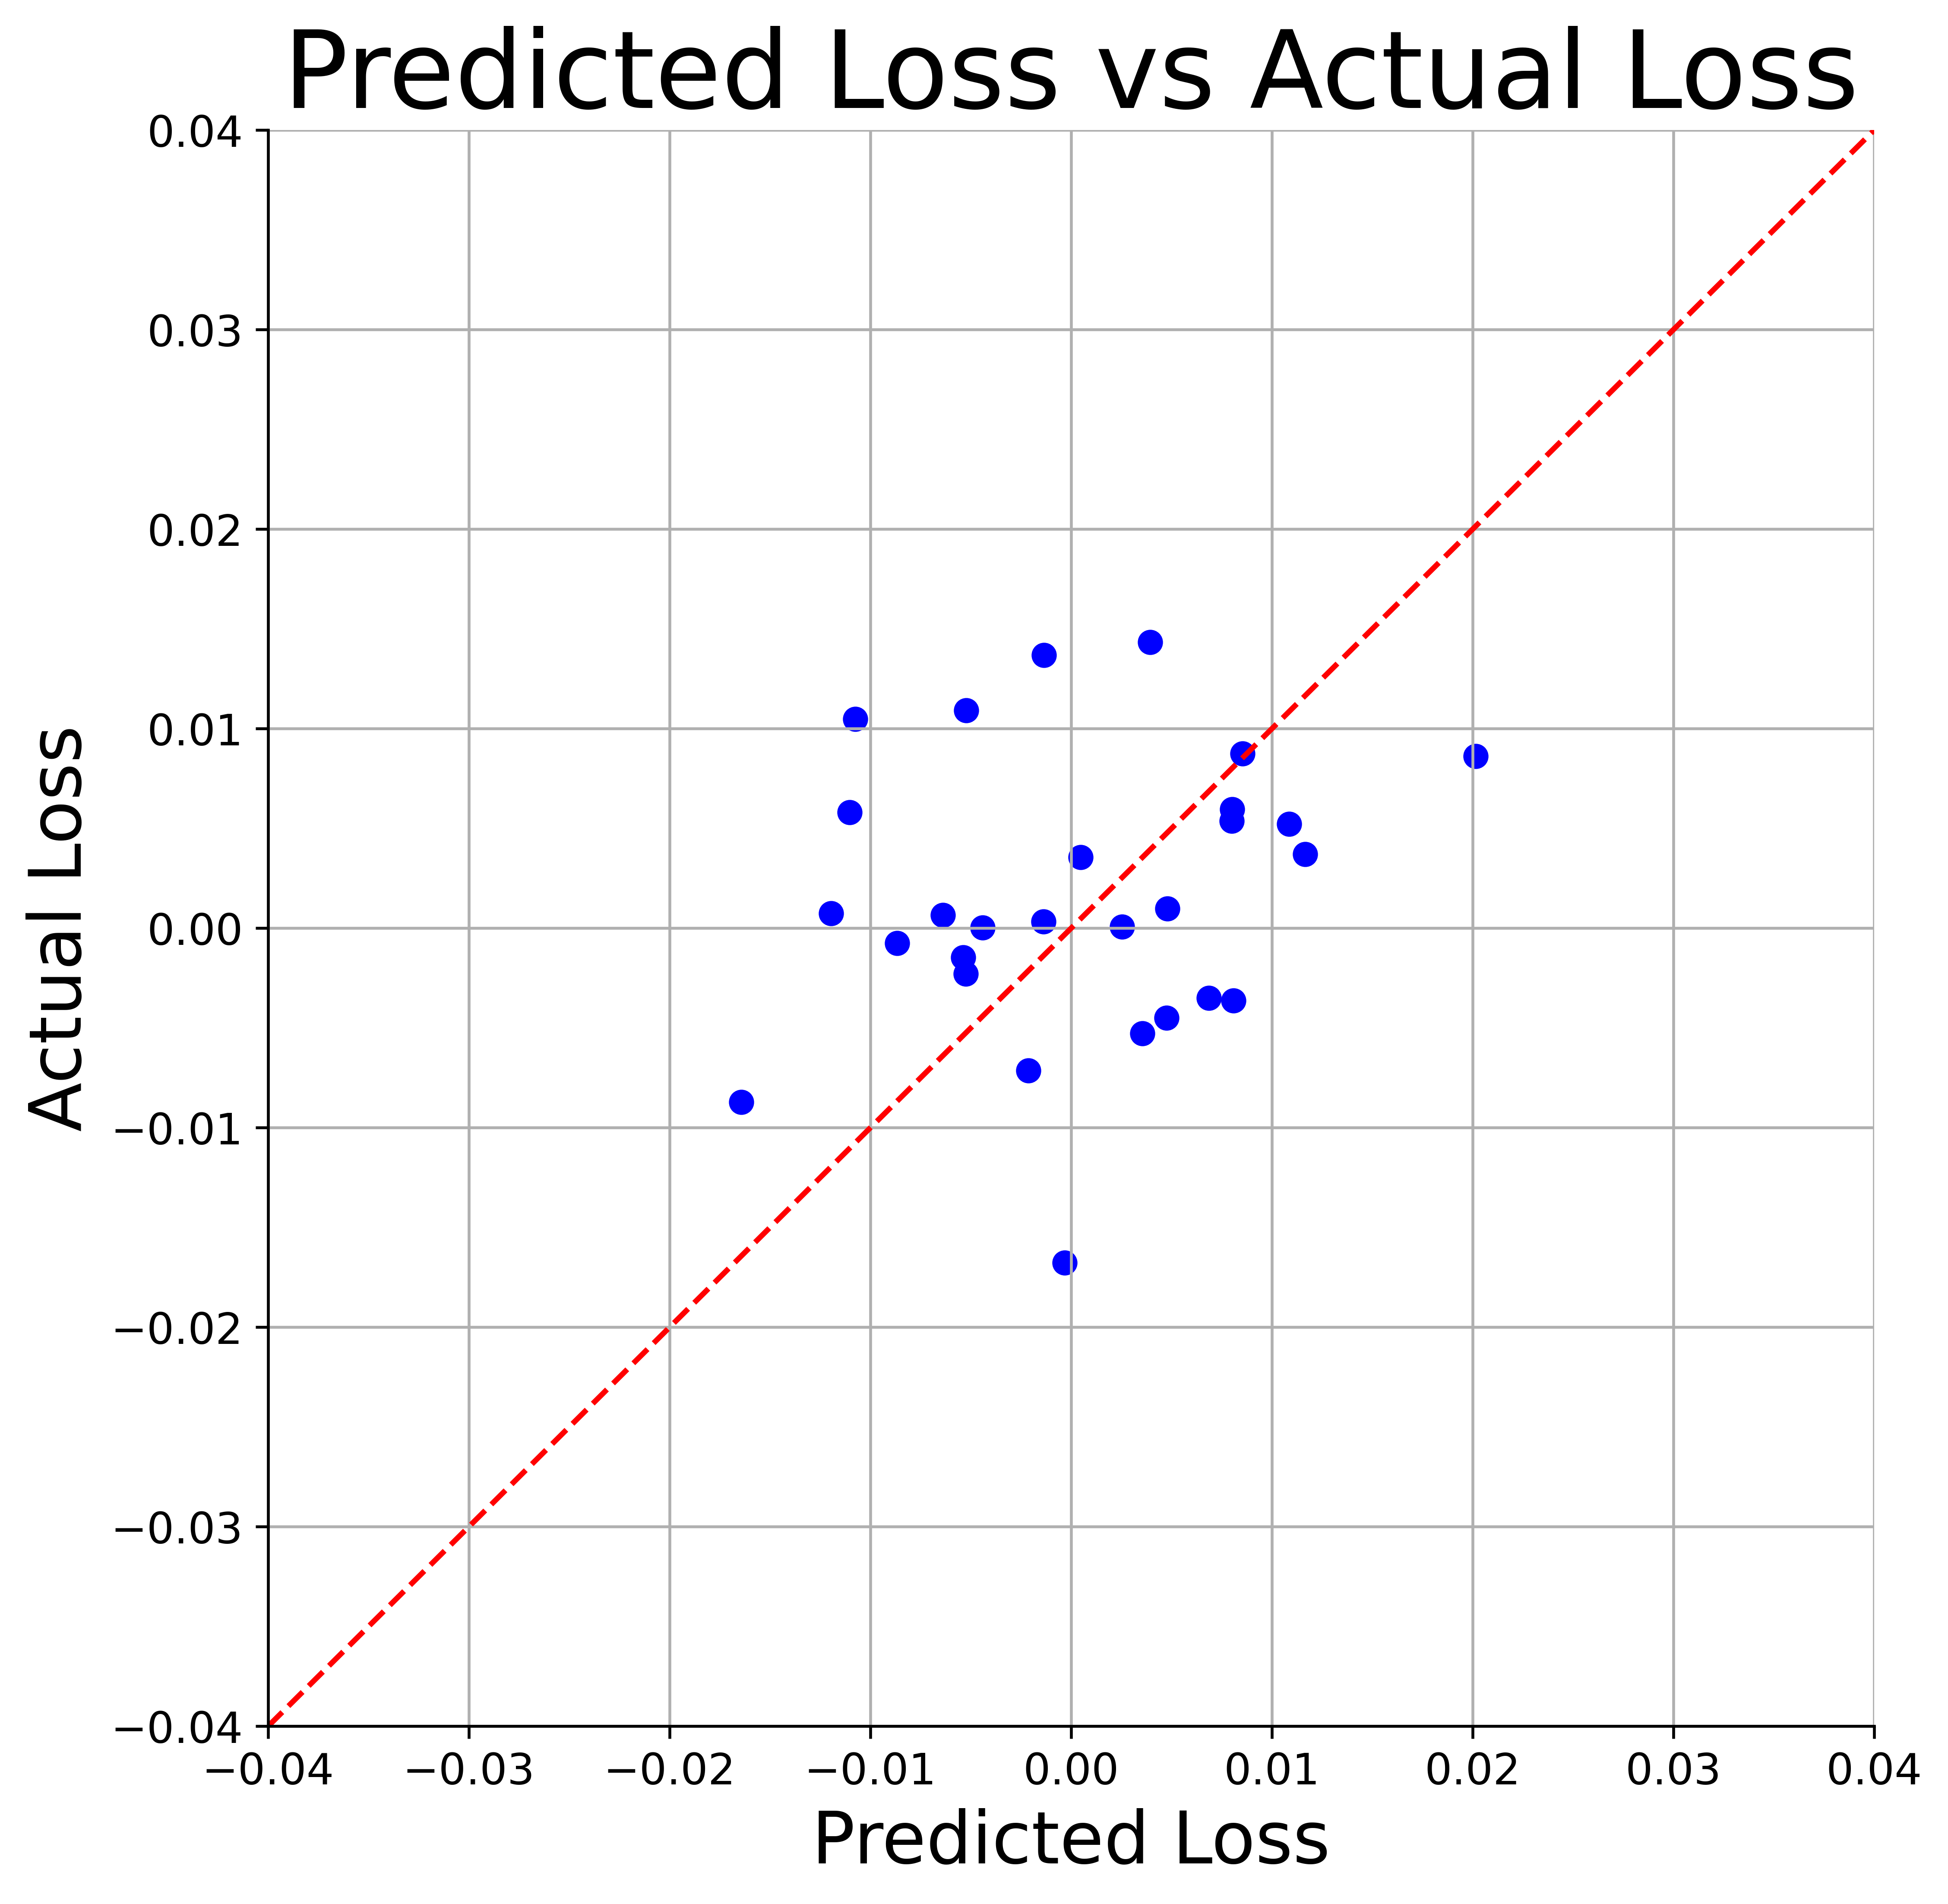

In [8]:
import matplotlib.pyplot as plt

# Data
#predicted_loss_if = [0.004, 0.456, 0.135, 0.063, 0.022, -0.432, 0.003, 0.006, 0.003]
#predicted_loss_cs = [0.374, -0.339, -0.106, 0.228, -0.428, 0.093, 0.045, 0.332, 0.141]
#actual_loss = [0.088, 0.348, 0.125, 0.308, -0.017, 0.12, 0.145, -0.150, -0.421]

#predicted_loss_cs = short_high_losses
#actual_loss_high = short_high_losses
#predicted_loss_if = short_losses
#actual_loss = short_losses
# Plot
plt.figure(figsize=(8, 8))
plt.scatter(sums[:28], fake_linear, color='blue', marker='o')
#plt.scatter(predicted_loss_cs, actual_loss_high, color='green', marker='o')

plt.plot([-0.04, 0.04], [-0.04, 0.04], color='red', linestyle='--', linewidth=1.5, label='Diagonal')


# Labels and Title
plt.xlabel('Predicted Loss', fontsize = 20)
plt.ylabel('Actual Loss', fontsize = 20)
plt.title('Predicted Loss vs Actual Loss', fontsize=30)
plt.tick_params(axis='both', labelsize=12)

# Set axis limits
plt.xlim(-0.04, 0.04)
plt.ylim(-0.04, 0.04)

# Grid and Show plot
plt.grid(True)
plt.savefig("predicted_actual.png", dpi=300, bbox_inches='tight')
plt.show()


In [13]:
#split into 900 sub-trajs, each one is length 22
#each of the original 100 traj are split into 9 sub-trajs
#if we get most influential is 2
#then this the same as accessing ep[0], and taking the indices [44:65]
#if we get most influential is 10
#then this the same as accessing ep[1], and taking the indices [22:43]
#so we should be accessing ep[num // 9], and taking indices [(num % 9) * 22: (num % 9) * 22 + 21]
print(obs, act[0])

[-0.05138194 -0.9986791   3.154986  ] 0.016921638


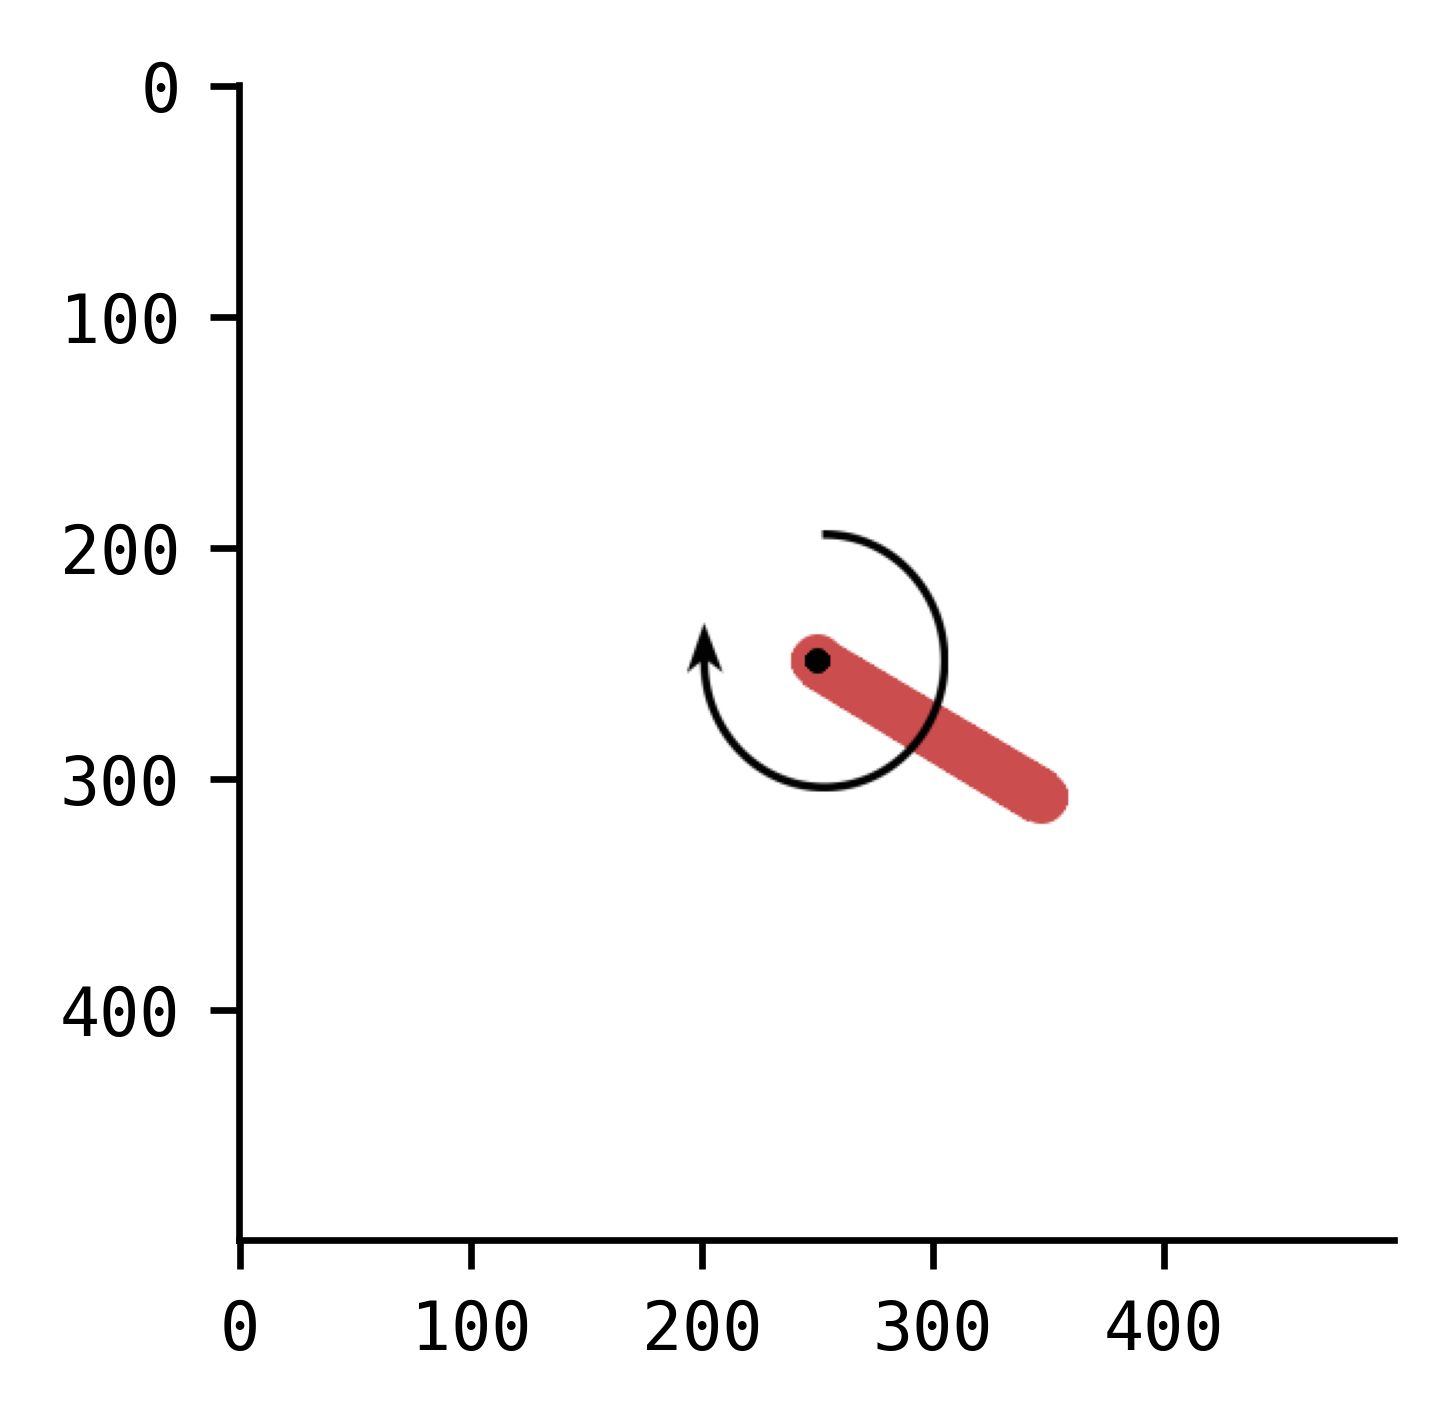

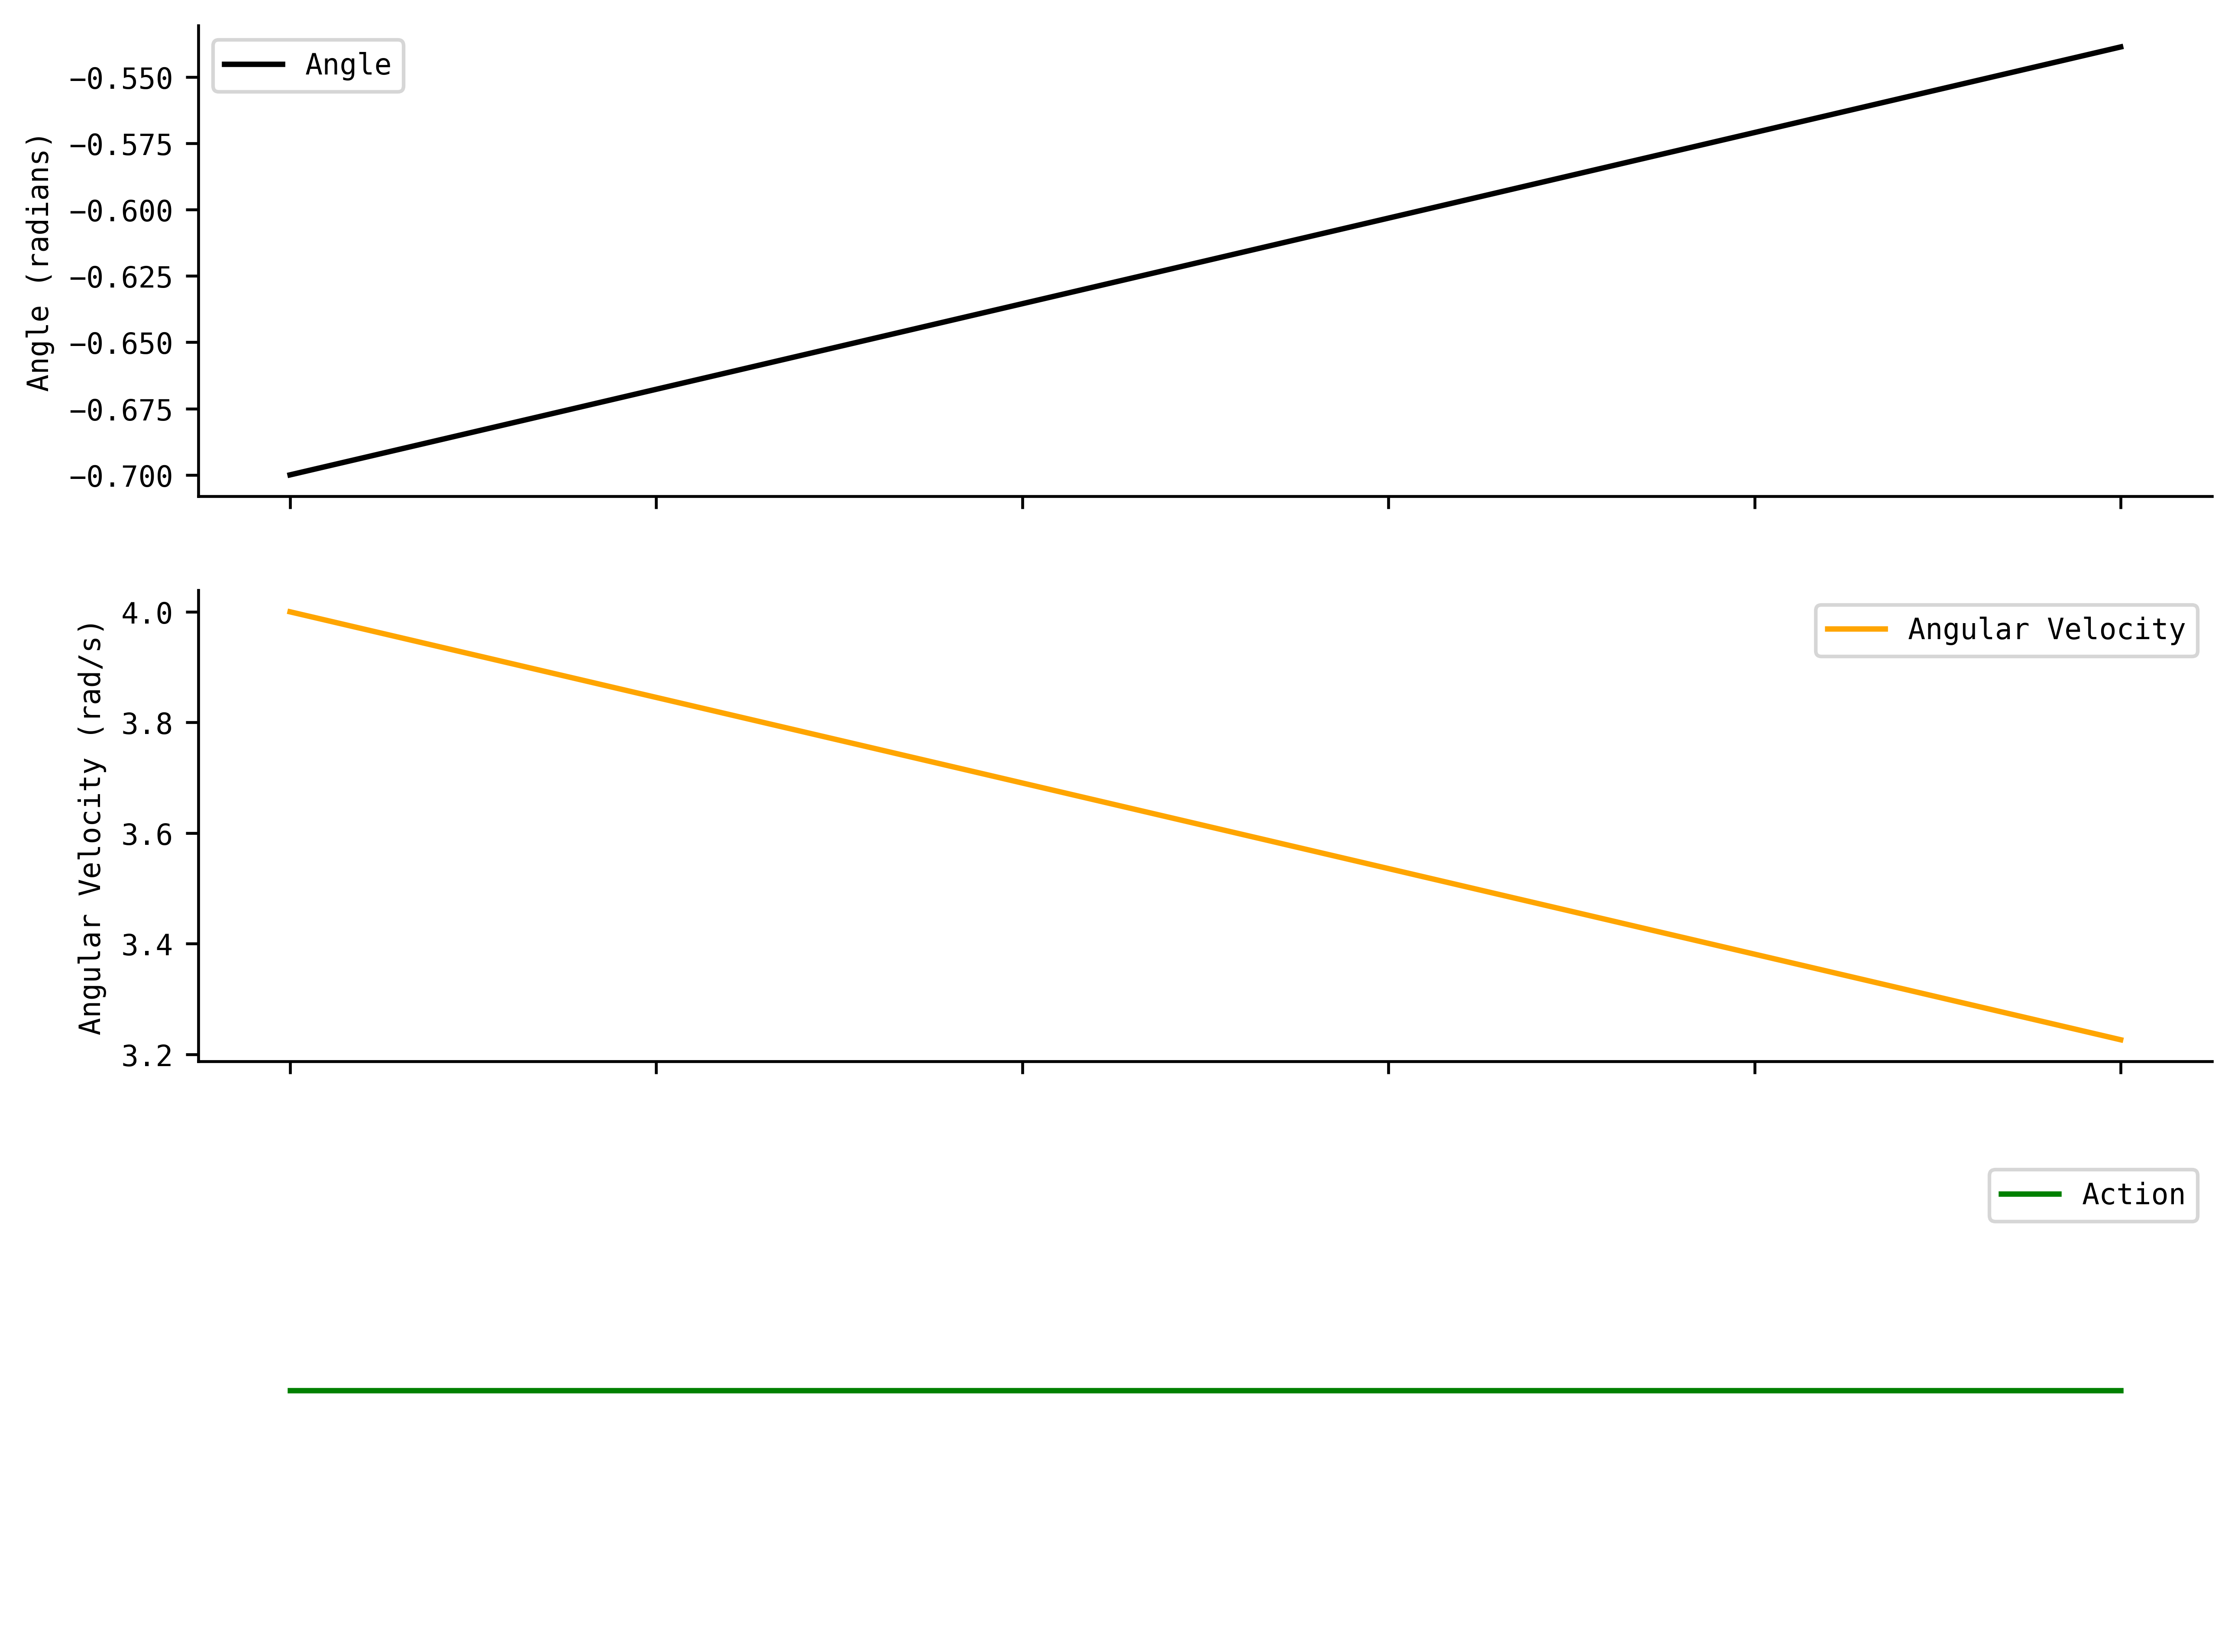

In [58]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
from IPython import display
mpl.rcParams['font.family'] = ['DejaVu Sans Mono']
import random
import math

# Create the Pendulum environment
env = gym.make('CustomPendulum-v0')

# Initialize lists to store trajectories
angles = []
angular_velocities = []
actions = []

# Generate Random Action

# Reset the environment to get the initial state
print(train_dataset[0][0][1], train_dataset[0][0][0])
custom_angle = math.atan2(train_dataset[0][0][1], train_dataset[0][0][0])
#custom_start = [custom_angle, ep_obs[0][2]]
custom_start = [-0.7, 4]
env.reset(custom_start = custom_start)
#state = env.reset(custom_start = [ 0.5311869,  -0.8472547,  -0.53876173])
init = env.state
done = False

# Run the simulation
frame = 0
states = []
rewards = []
dones = []
utils = []
env_states = []
for i in range(2):
    #if frame % 3 == 0:
    plt.imshow(env.render(mode = "rgb_array"))  # Render the environment for visualization (optional)
    display.display(plt.gcf())
    display.clear_output(wait = True)
    # Random action for simplicity, replace with your policy if needed
    action = [-2]
    
    # Take a step in the environment
    env_states.append(env.state)
    state = env.state
    next_state, reward, done, _ = env.step(action)
    
    # Append data to the lists
    utils.append(env.unwrapped.state)
    states.append(state)
    #angles.append(math.atan2(state[1], state[0]))
    #angular_velocities.append(state[2])
    angles.append(env.angle_normalize(state[0]))
    angular_velocities.append(state[1])
    actions.append(action)
    
    # Update state
    #next_angle = math.atan2(ep_obs[i + 1][1], ep_obs[i + 1][0])
    #state = [ep.observations[i + 1][0], ep.observations[i + 1][1], ep.observations[i + 1][2]]
    #state = [next_angle, ep_obs[i + 1][2]]
    #state = env.unwrapped.state
    frame = frame + 1

# Close the environment
env.close()

# Convert lists to numpy arrays for easier plotting
angles = np.array(angles)
angular_velocities = np.array(angular_velocities)
actions = np.array(actions)

# Plot the trajectories
fig, axs = plt.subplots(3, figsize=(10, 8), sharex=True)

# Angle over time
axs[0].plot(angles, label='Angle')
axs[0].set_ylabel('Angle (radians)')
axs[0].legend()

# Angular velocity over time
axs[1].plot(angular_velocities, label='Angular Velocity', color='orange')
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].legend()

# Actions over time
axs[2].plot(actions, label='Action', color='green')
axs[2].set_ylabel('Action')
axs[2].set_xlabel('Time Step')
axs[2].legend()

plt.axis('off')
plt.show()

In [19]:
sac = d3rlpy.algos.SAC()
os.chdir('d3rlpy_logs/Nov0_DEF')
files = os.listdir()
sac.build_with_dataset(short_dataset)
sac.load_model('model_50000.pt')
os.chdir('../../')

In [9]:

def rollout(states, actions, rewards, episode_terminals, index):
    states[:, 1] *= -1
    states[:, [0, 1]] = states[:, [1, 0]]
    #print(states)

    #print((math.atan2(temp[0], temp[1]) + math.pi/2) / math.pi)

    episode_terminals = episode_terminals.astype(float)
    episode_terminals[198] = 1.0

    #print("###")
    #print(states[198])
    #print(actions[198])
    #print(rewards[198])
    #print(episode_terminals[198])
    rollout_dict = {
        'states': states.tolist(),
        'actions': actions.tolist(),
        'rewards': rewards.tolist(),
        'episode_terminals': episode_terminals.tolist()
    }
    with open('rollout/rollout' + str(index) + '.json', 'w') as file:
        json.dump(rollout_dict, file, indent = 4)

In [220]:
!pip show gym

Name: gym
Version: 0.24.1
Summary: Gym: A universal API for reinforcement learning environments
Home-page: https://www.gymlibrary.ml/
Author: Gym Community
Author-email: jkterry@umd.edu
License: MIT
Location: /nethome/ezhou66/.local/lib/python3.8/site-packages
Requires: cloudpickle, importlib-metadata, numpy, gym-notices
Required-by: d4rl, d3rlpy


KeyboardInterrupt: 

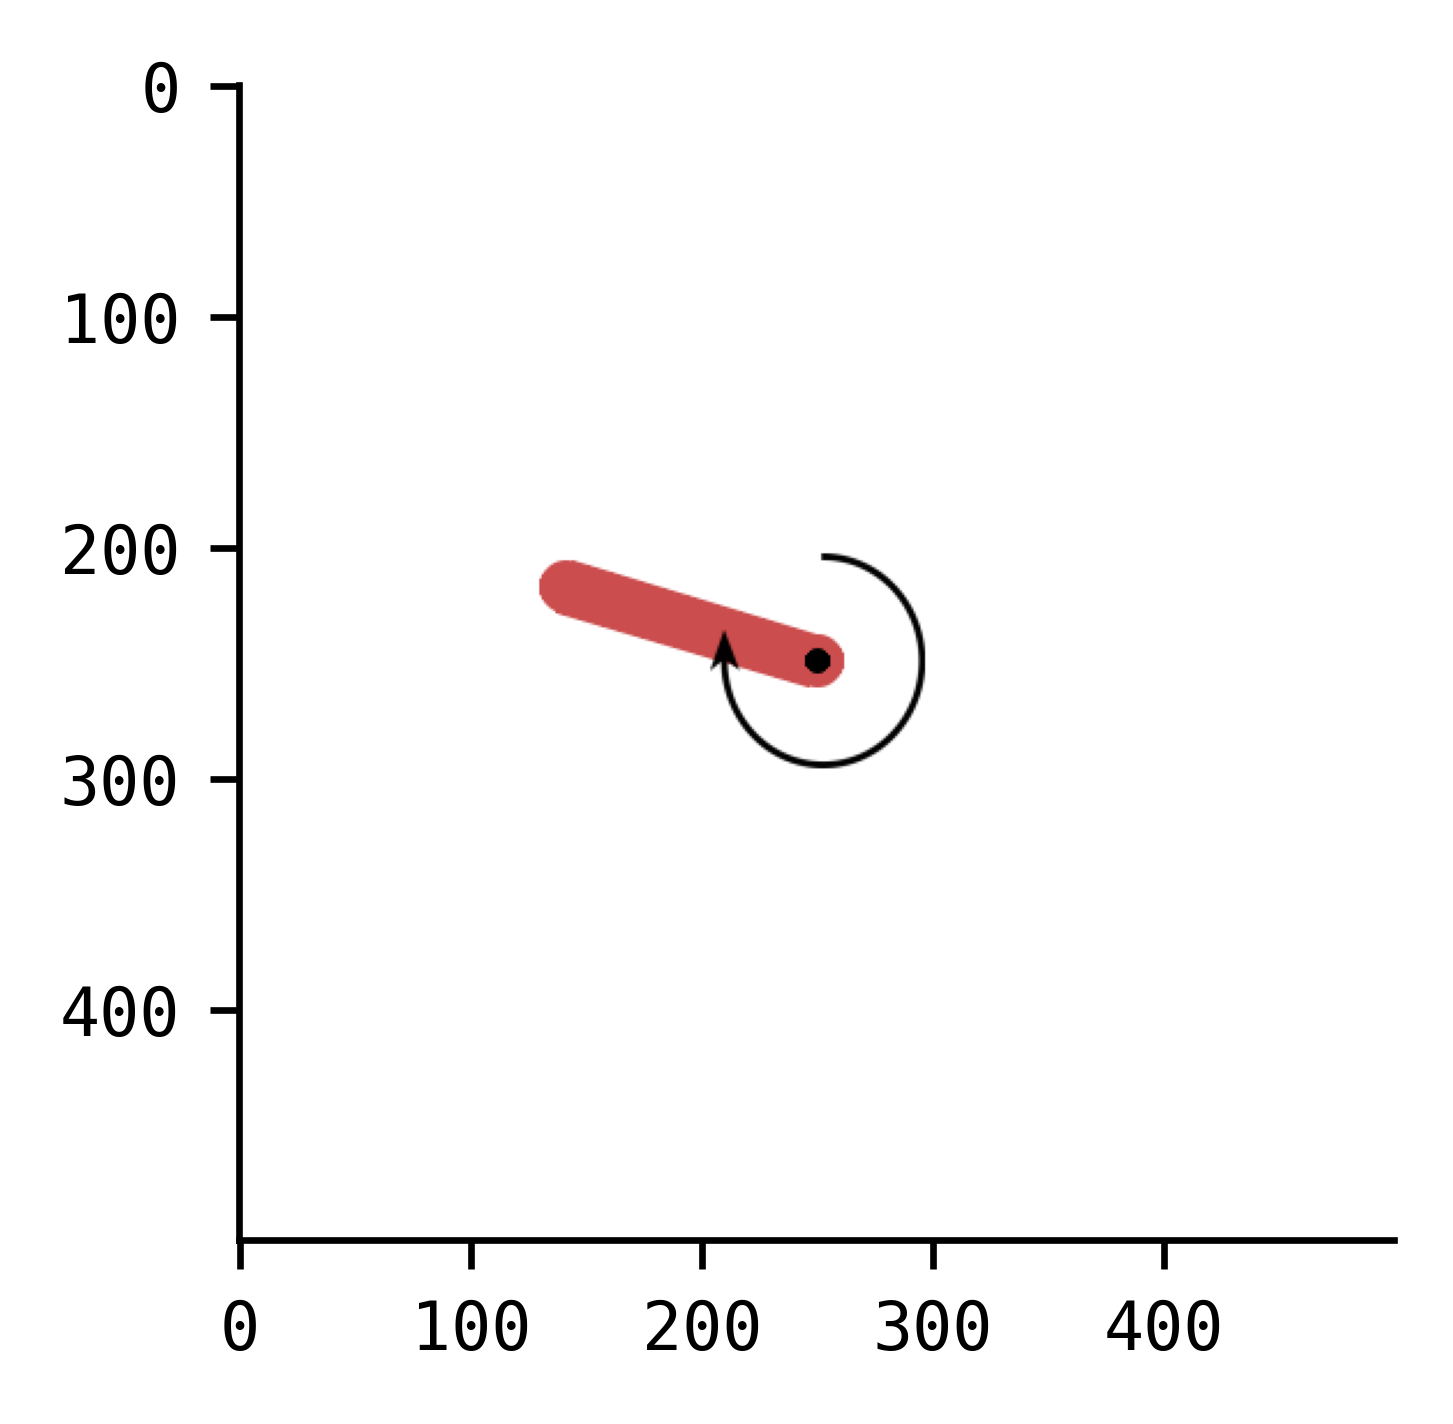

In [20]:
import matplotlib
import matplotlib.font_manager
import matplotlib.pyplot as plt
from IPython import display
mpl.rcParams['font.family'] = ['DejaVu Sans Mono']

#for j in range(10):
# Create the Pendulum environment
env = gym.make('Pendulum-v1')

# Initialize lists to store trajectories
angles = []
angular_velocities = []
actions = []
rewards = []
dones = []
old_states = []
states = []

# Reset the environment to get the initial state
state = env.reset()
done = False
print(state)

# Run the simulation
frame = 0
for i in range(100):
    if frame % 3 == 0:
        plt.imshow(env.render(mode = 'rgb_array'))  # Render the environment for visualization (optional)
        display.display(plt.gcf())
        display.clear_output(wait = True)
    # Random action for simplicity, replace with your policy if needed
    #action = env.action_space.sample()

    #temp_state = np.array([-state[1], state[0], state[2]])
    #states.append(temp_state)
    action = sac.predict([state])[0]
    action *= 2

    #state[0], state[1], state[2] = -state[1], state[0], state[2]
    
    # Take a step in the environment
    next_state, reward, done, _ = env.step(action)
    
    # Append data to the lists
    angles.append(math.atan2(state[0], state[1] / math.pi))
    angular_velocities.append(state[2])
    actions.append(action)
    rewards.append(reward)
    dones.append(done)
    
    # Update state
    state = next_state
    frame = frame + 1

# Close the environment
env.close()

# Convert lists to numpy arrays for easier plotting
angles = np.array(angles)
angular_velocities = np.array(angular_velocities)
actions = np.array(actions)
rewards = np.array(rewards)
episode_terminals = np.array(dones)
states = np.array(states)
old_states = np.array(old_states)

# Plot the trajectories
fig, axs = plt.subplots(3, figsize=(10, 8), sharex=True)

# Angle over time
axs[0].plot(angles, label='Angle')
axs[0].set_ylabel('Angle (radians)')
axs[0].legend()

# Angular velocity over time
axs[1].plot(angular_velocities, label='Angular Velocity', color='orange')
axs[1].set_ylabel('Angular Velocity (rad/s)')
axs[1].legend()

# Actions over time
axs[2].plot(actions, label='Action', color='green')
axs[2].set_ylabel('Action')
axs[2].set_xlabel('Time Step')
axs[2].legend()

plt.show()
#rollout(states, actions, rewards, episode_terminals, j)


In [219]:
#print(np.max(states[:, 2]))
#print(np.min(states[:, 2]))
#print(np.max(states[:, 1]))
#print(old_states[:10])
print(np.min(states[:, 0]), np.max(states[:, 0]))
print(np.min(states[:, 1]), np.max(states[:, 1]))
print(np.min(states[:, 2]), np.max(states[:, 2]))
print(np.min(actions), np.max(actions))
print(states)
print(dir(env))

0.26699385046958923 0.35190460085868835
-0.9636982083320618 -0.9360358715057373
-0.07629026472568512 0.06918143481016159
0.6265411 0.8152843
[[ 0.30389163 -0.95270663  0.06918143]
 [ 0.32512239 -0.94567198  0.05591582]
 [ 0.34045845 -0.94025958  0.04065827]
 [ 0.34946489 -0.93694949  0.02398867]
 [ 0.3519046  -0.93603587  0.00651292]
 [ 0.34766513 -0.93761879 -0.01131333]
 [ 0.33683401 -0.94156402 -0.02881844]
 [ 0.31964964 -0.94753581 -0.0454817 ]
 [ 0.29627329 -0.95510322 -0.06142829]
 [ 0.26699385 -0.96369821 -0.07629026]]
['__annotations__', '__class__', '__class_getitem__', '__delattr__', '__dict__', '__dir__', '__doc__', '__enter__', '__eq__', '__exit__', '__format__', '__ge__', '__getattr__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__orig_bases__', '__parameters__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__slots__', '__str__', '__subclasshook__', '__weakre

In [121]:
##SHORT_DATASET: Observations x[-1, 1], y[-1, 1], tau[-8, 8]; Actions[-2, 2]; Rewards [-16, 0]; 
##Gym: Observations x[-1, 1], y[-1, 1], tau[-8, 8]; Actions[-2, 2]; Rewards [-16, 0]; 

minim = float('inf')
maxim = -float('inf')
rewards = rewards
for i in range(len(rewards)):
    if minim > rewards[i]:
        minim = rewards[i]
    if maxim < rewards[i]:
        maxim = rewards[i]
print(minim, maxim)

-15.12239243519035 -0.0002314283950439012


In [122]:
from d3rlpy.algos import SAC
os.chdir('d3rlpy_logs/Pend_SAC')
env_dataset, env = d3rlpy.datasets.get_pendulum('random')
files = os.listdir()
sac = SAC()
sac.build_with_dataset(env_dataset)
sac.load_model('model_990000.pt')
os.chdir('../../')

In [138]:
states = [state[np.newaxis, ...] for state in states]
actions = sac.predict(states[0])
print(states[0])
print(actions)

[[[-0.95574737 -0.05199996  0.0305903 ]]]
[[[-0.60342455]]]


In [242]:
def process_batch(data_batch, target_batch):
    # Move batch to device
    data_batch = data_batch.to(device)
    target_batch = target_batch.to(device)
    
    # Forward pass
    with torch.no_grad():
        output = policy_net(data_batch)

    # Ensure target tensor is of the correct shape (1D or 0D for classification)
    # For simplicity, assuming single-label classification here
    # If multi-label, adjust target tensor shape accordingly
    # Calculate loss (example for classification)
    criterion = nn.CrossEntropyLoss()
    loss = criterion(output, target_batch)
    
    return loss

# Iterate through DataLoader
for batch_idx, (data_batch, target_batch) in enumerate(train_dataloader):
    print(data_batch, target_batch)
    print(data_batch.shape)
    print(target_batch.shape)
    print(type(target_batch))
    target_batch = target_batch.type(torch.LongTensor)
    print(type(target_batch))
    # Process the data batch
    loss = process_batch(data_batch, target_batch)
    print(f"Batch {batch_idx + 1}, Loss: {loss.item()}")

tensor([[-0.3189,  0.0074,  0.1155]]) tensor([-0.1338])
torch.Size([1, 3])
torch.Size([1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Batch 1, Loss: 0.0
tensor([[-0.1268, -0.0200,  0.6752]]) tensor([0.1013])
torch.Size([1, 3])
torch.Size([1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Batch 2, Loss: 0.0
tensor([[-0.9357, -0.0052,  0.0285]]) tensor([0.0533])
torch.Size([1, 3])
torch.Size([1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Batch 3, Loss: 0.0
tensor([[-0.7810,  0.0272, -0.0382]]) tensor([-0.2144])
torch.Size([1, 3])
torch.Size([1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Batch 4, Loss: 0.0
tensor([[-0.0624,  0.0286, -0.9483]]) tensor([0.0187])
torch.Size([1, 3])
torch.Size([1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Batch 5, Loss: 0.0
tensor([[-0.5446, -0.0026, -0.2982]]) tensor([-0.0476])
torch.Size([1, 3])
torch.Size([1])
<class 'torch.Tensor'>
<class 'torch.Tensor'>
Batch 6, Loss: 0.0
tensor([[-0.8240, -0.0062,  0.1509]]) tensor([0.0829])
torch.Size([

In [5]:
from gym.wrappers.record_video import RecordVideo

# start virtual display
d3rlpy.notebook_utils.start_virtual_display()

# wrap RecordVideo wrapper
new_env = RecordVideo(gym.make("CartPole-v1", render_mode="rgb_array"), './video')

# evaluate
d3rlpy.metrics.evaluate_qlearning_with_environment(sac, new_env)

AttributeError: module 'd3rlpy' has no attribute 'notebook_utils'

In [7]:
#print(dataset['observations'][999])
#print(dataset['next_observations'][999])
#print(dataset['observations'][1000])
#from operator import itemgetter
#trajectories = []

print(dataset['actions'][0])

#for i in range(0, 1000, 1):
#    trajectory = []
#    for j in range(0, 1000, 1):
#        step = [dataset['observations'][i + j], dataset['observations'][i + j], dataset['observations'][i + j], dataset['observations'][i + j]]


[ 0.78721416  0.8764658  -0.40471458 -0.8212363  -0.47737995 -0.89712983]


In [8]:
print(len(dataset['observations']))
print(len(dataset['actions']))
print(dataset['next_observations'])
keys_list = dataset.keys()
print(keys_list)
print(dataset['observations'])

1000000
1000000
[[ 6.8606213e-02 -6.3024499e-02  1.2627374e-01 ... -5.8347492e+00
   2.9682204e-01 -6.3176913e+00]
 [ 4.3157995e-02 -3.0180864e-02  7.2917409e-02 ... -4.4513804e-01
   4.5849690e+00  2.0110707e+00]
 [-1.2178257e-02 -8.7656761e-03 -3.1841108e-01 ...  5.3954129e+00
   2.9676287e+00  7.2686763e+00]
 ...
 [-3.5350587e-02 -1.3052115e-01 -1.6677204e-01 ... -3.3741906e+00
  -4.8845510e+00 -5.1081996e+00]
 [-9.0780985e-03 -1.5547317e-01  6.0090959e-01 ... -2.2751564e+01
  -3.7737691e+00 -3.9162564e+00]
 [-4.3755256e-02 -5.7433613e-02  8.7629533e-01 ... -8.6782470e-02
  -7.2263919e-02  2.1646678e+00]]
dict_keys(['actions', 'infos/action_log_probs', 'infos/qpos', 'infos/qvel', 'metadata/algorithm', 'metadata/iteration', 'metadata/policy/fc0/bias', 'metadata/policy/fc0/weight', 'metadata/policy/fc1/bias', 'metadata/policy/fc1/weight', 'metadata/policy/last_fc/bias', 'metadata/policy/last_fc/weight', 'metadata/policy/last_fc_log_std/bias', 'metadata/policy/last_fc_log_std/weight', 